# Basic regression: Predict Corrosion as Epit

*This notebook is based on the [tutorial notebook](https://www.tensorflow.org/tutorials/keras/regression) provided by TensorFlow.*

This Notebook takes the data that has been cleaned and imputed in book 2. If I have time I would produce another set of the data with the imputation according to each metal plot as file impute Nan Intuitively.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

## Setup

In [1]:
import datetime, time, os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,  mean_squared_error, mean_absolute_error

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.8.0


### Setup for TensorBoard

We will use the TensorBoard to visualize some results. You can find more information and the board itself at the end of this notebook, but we will define the path were the information should be stored directly here at the beginning. 

In [3]:
# With this command you can clear any logs from previous runs
# If you want to compare different runs you can skip this cell 
!rm -rf my_logs/

In [4]:
# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")
# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [5]:
# Create function for using callbacks; "name" should be the name of the model you use
def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)

## The Alloys Data
The dataset is available from book 2_Metal Features, already cleaned.

In [6]:
Alloys= pd.read_csv("../data/Alloy_Inter.csv")

In [7]:
Alloys.head(5)

,Cl,Test_Temp,pH,M_Al,M_Fe,M_HEA,M_NiCrMo,M_Other,Fe,Cr,...,Ta,Re,Ce,Ti,Co,B,Mg,Y,Gd,Epit
0,0.01,50.0,7.8,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,287.0
1,0.01,50.0,7.8,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,260.0
2,0.02,50.0,7.8,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,218.0
3,0.09,50.0,7.8,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.0
4,0.55,50.0,8.2,0.0,1.0,0.0,0.0,0.0,69.7,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,94.0


### Split the data into train and test

Now we'll split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our models.

In [8]:
Alloys_train = Alloys.sample(frac=0.8, random_state=42)
Alloys_test = Alloys.drop(Alloys_train.index)

In [9]:
Alloys.columns

Index(['Cl', 'Test_Temp', 'pH', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Cr', 'Ni', 'Mo', 'W', 'Nb', 'C', 'Si', 'Mn', 'Al', 'V', 'Ta',
       'Re', 'Ce', 'Ti', 'Co', 'B', 'Mg', 'Y', 'Gd', 'Epit'],
      dtype='object')

### Inspecting the data

Let's have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

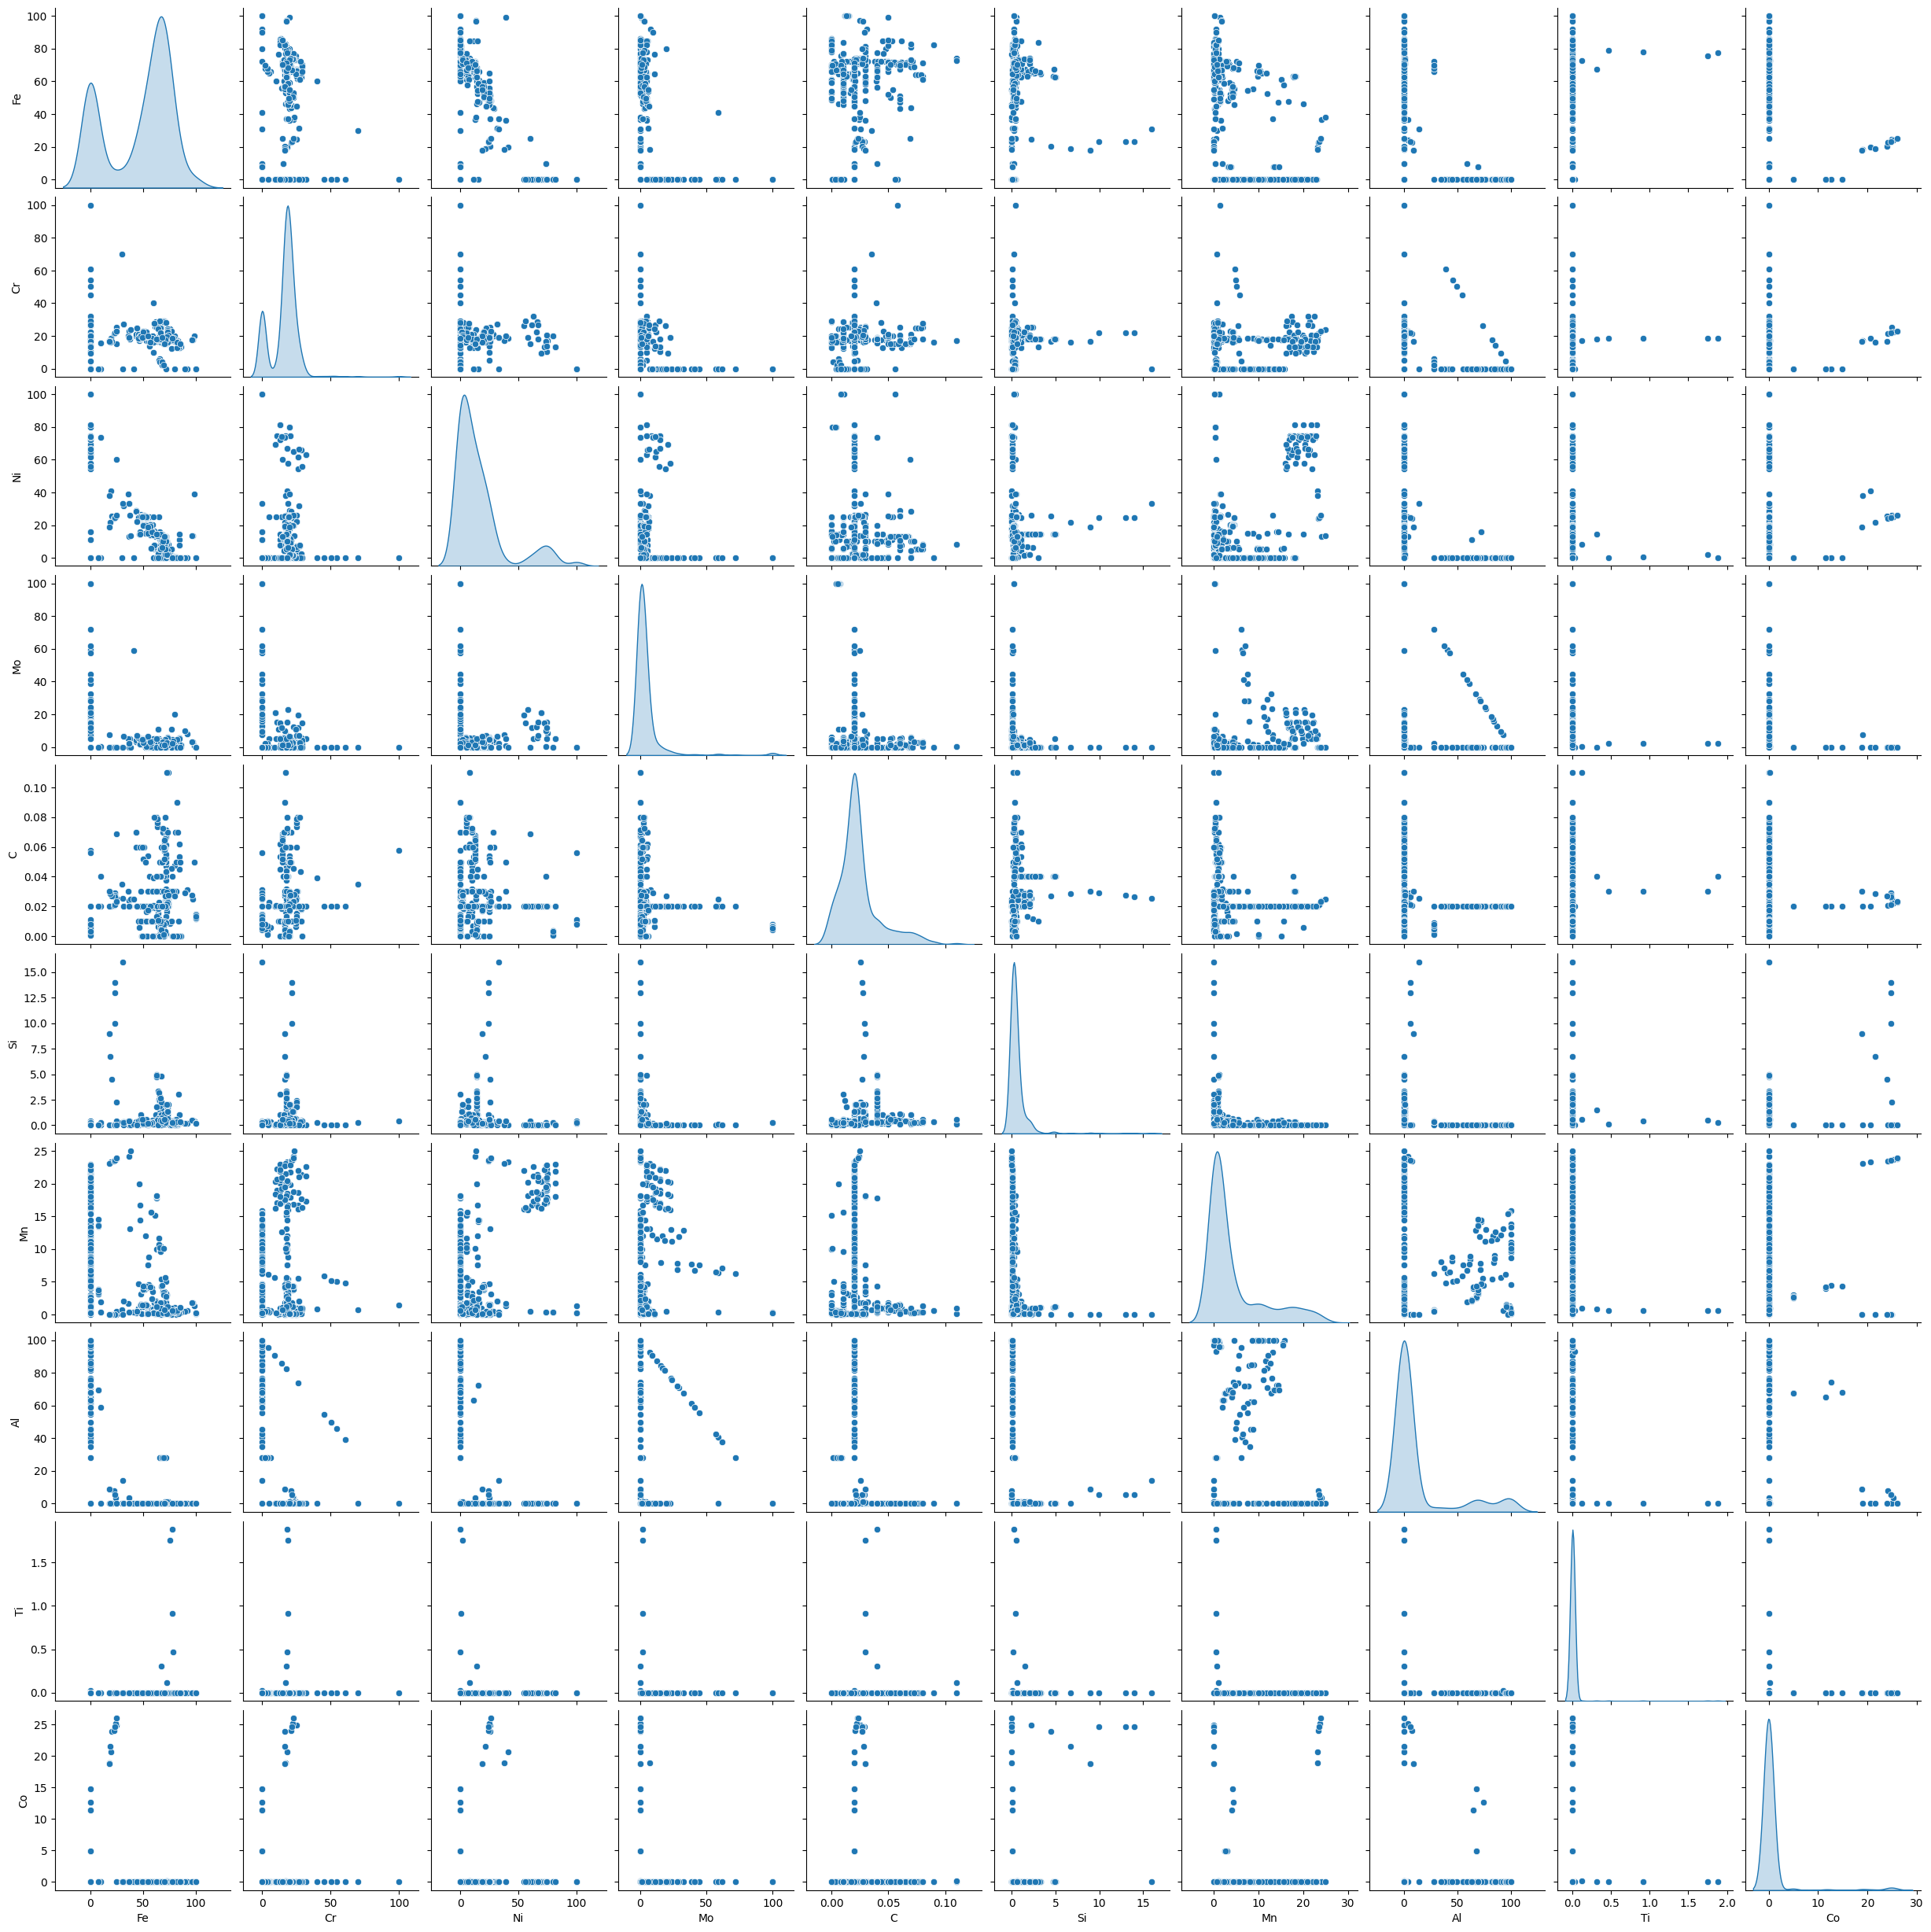

In [10]:
sns.pairplot(Alloys_train[['Fe', 'Cr', 'Ni', 'Mo', 'C', 'Si', 'Mn', 'Al', 'Ti', 'Co']], diag_kind='kde');

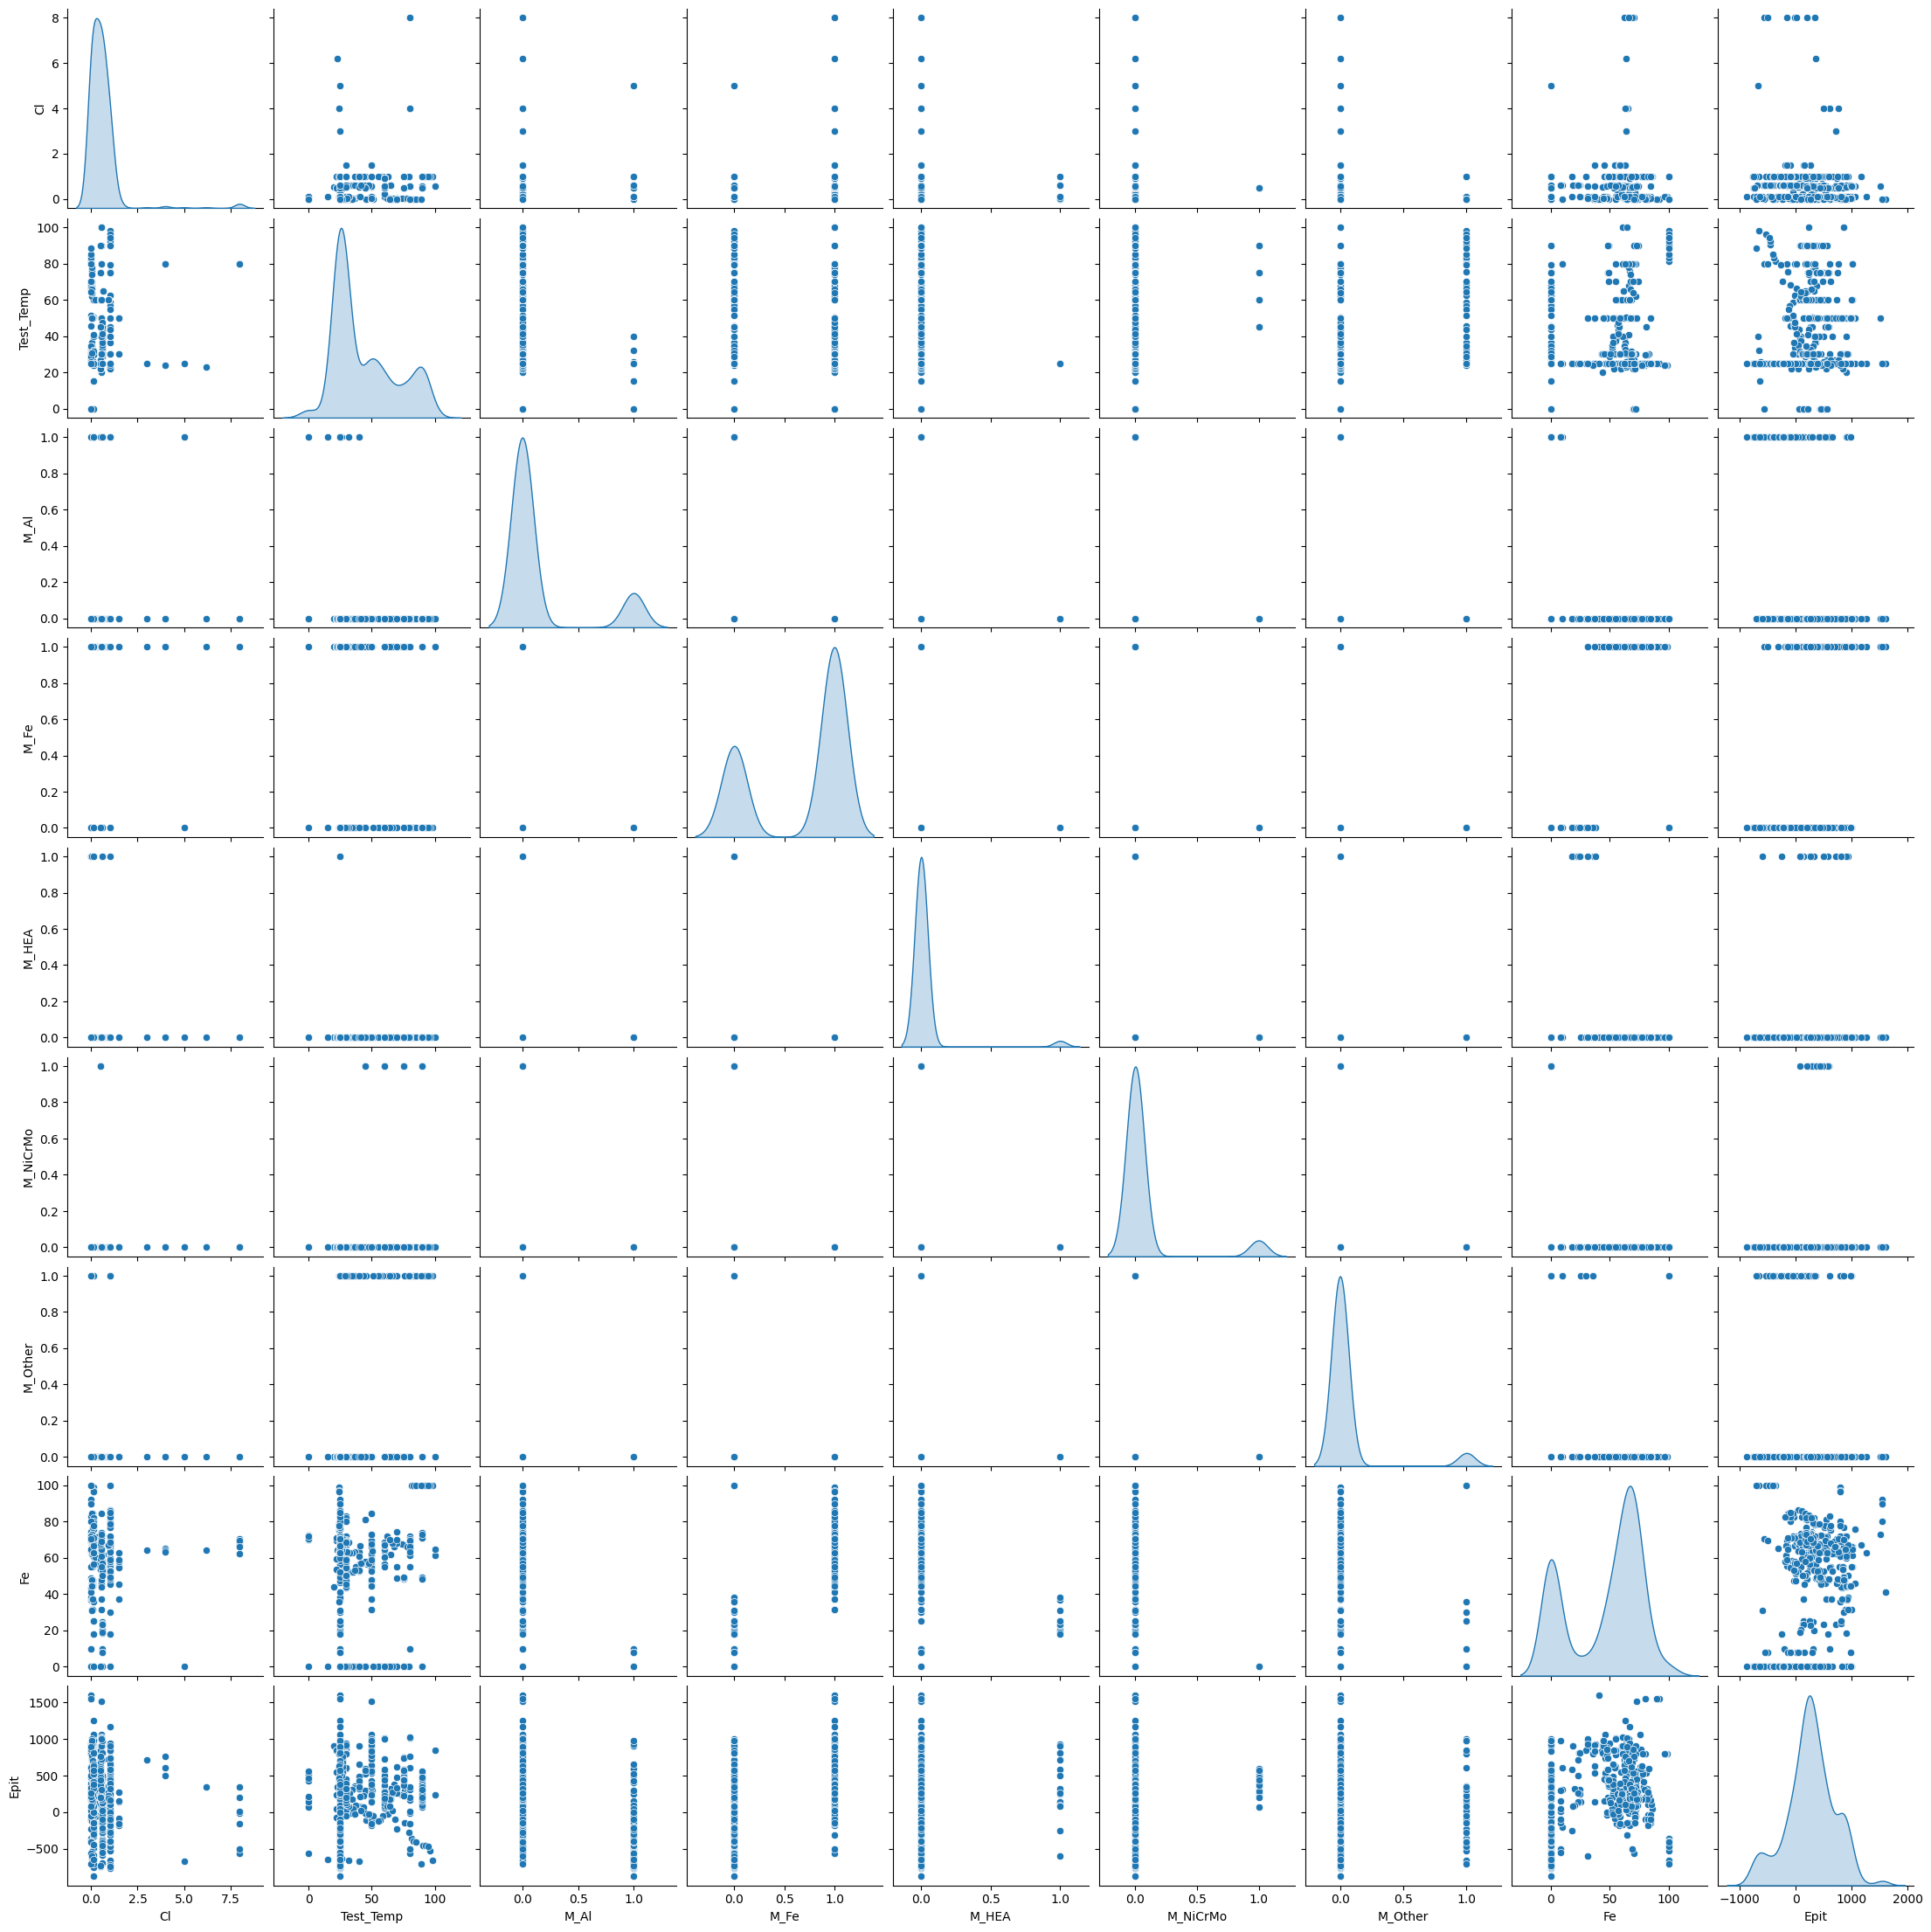

In [11]:
sns.pairplot(Alloys_train[['Cl', 'Test_Temp', 'M_Al', 'M_Fe', 'M_HEA', 'M_NiCrMo', 'M_Other',
       'Fe', 'Epit']], diag_kind='kde');

Also look at the overall statistics, note how each feature covers a very different range:

In [12]:
Alloys_test.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Cl,152.0,0.512829,0.778407,0.0,0.100000,0.550000,0.612500,8.000000
Test_Temp,152.0,41.762336,22.188917,0.0,25.000000,30.000000,60.000000,100.000000
pH,152.0,6.013596,2.656505,0.0,5.115385,7.000000,7.200000,10.200000
M_Al,152.0,0.164474,0.371930,0.0,0.000000,0.000000,0.000000,1.000000
M_Fe,152.0,0.677632,0.468928,0.0,0.000000,1.000000,1.000000,1.000000
M_HEA,152.0,0.059211,0.236799,0.0,0.000000,0.000000,0.000000,1.000000
M_NiCrMo,152.0,0.026316,0.160602,0.0,0.000000,0.000000,0.000000,1.000000
M_Other,152.0,0.072368,0.259953,0.0,0.000000,0.000000,0.000000,1.000000
Fe,152.0,45.555132,30.463138,0.0,7.997500,58.470000,69.107500,100.000000
Cr,152.0,16.019731,9.606167,0.0,13.960000,18.000000,21.127500,60.000000


### Split features from labels

Before we can start with the modelling process we need to separate our label from the dataset. This label is the value that we will train the model to predict.

In [13]:
X_train = Alloys_train.copy()
X_test =  Alloys_test.copy()

y_train = X_train.pop('Epit')
y_test = X_test.pop('Epit')

## Sklearn

Before we start using TensorFlow and Keras, let's train a simple `LinearRegression` model from sklearn for comparison. 

In [14]:
# Scaling the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Initalizing and training the model 
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [16]:
# Making predictions 
y_pred = lin_reg.predict(X_test_scaled)
y_pred_train= lin_reg.predict(X_train_scaled)

In [17]:
mae= mean_absolute_error(y_test, y_pred).round(3)
RMSE= mean_squared_error(y_test, y_pred, squared=False).round(3)
R2 =  r2_score(y_test, y_pred).round(3)
Ratio = ((mean_squared_error(y_test, y_pred, squared=False))/(mean_absolute_error(y_test, y_pred))).round(3)

In [18]:
mae_t= mean_absolute_error(y_train, y_pred_train).round(3)
RMSE_t= mean_squared_error(y_train, y_pred_train, squared=False).round(3)
R2_t =  r2_score(y_train, y_pred_train).round(3)
Ratio_t= ((mean_squared_error(y_train, y_pred_train, squared=False))/(mean_absolute_error(y_train, y_pred_train))).round(3)

In [19]:
#Model Metrics
print("MAE for Lr Test:", mae, "MAE for Lr Train Data:", mae_t)
print("RMSE for Lr  Test:", RMSE, "RMSE for Lr  Train Data:", RMSE_t)
print("R2 for Lr  Test:", R2, "R2 for Lr  Train Data :", R2_t)
print("RMSE/MAE Ratio Test :", Ratio, "RMSE/MAE Ratio Test :", Ratio_t)

MAE for Lr Test: 307.424 MAE for Lr Train Data: 217.739
RMSE for Lr  Test: 767.215 RMSE for Lr  Train Data: 287.957
R2 for Lr  Test: -2.108 R2 for Lr  Train Data : 0.544
RMSE/MAE Ratio Test : 2.496 RMSE/MAE Ratio Test : 1.322


We'll store the result in a dictionary in order to compare the results of different models in the end.

In [20]:
test_results = {mae, RMSE, R2, Ratio}#mae_t, RMSE_t, R2_t, Ratio_t

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [21]:
X_train.describe().transpose()[['mean', 'std']]

,mean,std
Cl,0.572582,0.969691
Test_Temp,43.780633,24.548171
pH,5.734497,2.793968
M_Al,0.152961,0.360246
M_Fe,0.675987,0.468390
M_HEA,0.029605,0.169635
M_NiCrMo,0.077303,0.267291
M_Other,0.064145,0.245212
Fe,46.303651,30.769358
Cr,15.973809,9.870155


It is good practice to normalize features that use different scales and ranges. In our case we have the metal features, Cl, pH, Test_temp that present no gausian shape, so it is necesary to normalise them rather than standarise them.

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [22]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [23]:
normalizer.adapt(np.array(X_train))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-20 23:14:04.811139: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-20 23:14:04.812407: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-11-20 23:14:04.961285: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-20 23:14:05.070202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-20 23:14:05.089449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


This calculates the mean and variance, and stores them in the layer. 

In [24]:
normalizer.mean.numpy()

array([[ 0.573, 43.781,  5.734,  0.153,  0.676,  0.03 ,  0.077,  0.064,
        46.304, 15.974, 16.249,  4.51 ,  0.18 ,  0.515,  0.024,  0.593,
         4.368, 12.992,  0.006,  0.023,  0.006,  0.354,  0.009,  0.696,
         0.01 ,  0.006,  0.039,  0.548]], dtype=float32)

When the layer is called it returns the input data, with each feature independently normalized. We can have a look at the first training instance and compare the original and normalized features:

In [25]:
first = np.array(X_train[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[ 0.1  24.    1.    0.    1.    0.    0.    0.   62.7  17.6  13.5   3.89
   0.    0.    0.03  0.53  1.72  0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.  ]]

Normalized: [[-0.49 -0.81 -1.7  -0.42  0.69 -0.17 -0.29 -0.26  0.53  0.16 -0.12 -0.05
  -0.12 -0.11  0.31 -0.05 -0.42 -0.44 -0.06 -0.1  -0.05 -0.12 -0.08 -0.18
  -0.04 -0.06 -0.06 -0.15]]


## Linear regression

Before building a DNN (deep neural network) model, let's start with a linear regression.

### One Variable

We'll start easy with a single-variable linear regression, to predict `Epit` from `Fe`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case we'll use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

1. Normalize the input `Fe`.
2. Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. First create the Fe `Normalization` layer:

In [26]:
Fe = np.array(X_train['Fe'])

Fe_normalizer = preprocessing.Normalization(input_shape = [1,], axis = None)
Fe_normalizer.adapt(Fe)

2022-11-20 23:14:19.521150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-20 23:14:19.537665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2. Then we'll build the sequential model:

In [27]:
Fe_model = tf.keras.Sequential([
    Fe_normalizer,
    layers.Dense(units=1)])

# We can print a summary of the model architecture with the following line:
Fe_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `Epit` from `Fe`.

Run the untrained model on the first 10 Fe values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [28]:
Fe_model.predict(Fe[:10]).shape

2022-11-20 23:14:26.088315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(10, 1)

In [29]:
Fe_model.predict(Fe[:10])

array([[ 0.316],
       [ 0.325],
       [ 0.199],
       [-0.892],
       [ 0.131],
       [-0.892],
       [ 0.59 ],
       [-0.892],
       [-0.892],
       [-0.185]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`). We'll also define the `metrics` to use the `mean_squared_error`.

In [30]:
Fe_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mae',
    metrics='mse')

Once the training is configured, use `Model.fit()` to execute the training:

In [31]:
%%time
history = Fe_model.fit(
    Alloys_train['Fe'], y_train,
    epochs=100,
    # suppress logging (if you want to see the output for the different epochs set the value to 1)
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    # Store information for TensorBoard
    callbacks=get_callbacks("Fe_model"))

2022-11-20 23:14:36.865222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-20 23:14:38.212513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 12.4 s, sys: 6.68 s, total: 19.1 s
Wall time: 19.8 s


Visualize the model's training progress using the stats stored in the `history` object.

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Show results from first 5 epochs
hist.head(2) 

,loss,mse,val_loss,val_mse,epoch
0,405.612732,253665.640625,407.350464,239691.328125,0
1,404.333710,252535.859375,406.144653,238628.078125,1


In [33]:
# Show results from last 5 epochs (loss and val_loss decreased)
hist.tail(2)

,loss,mse,val_loss,val_mse,epoch
98,332.777863,189968.890625,331.330322,184187.187500,98
99,332.443146,189649.437500,331.061737,183936.296875,99


In [34]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([300, 320])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Epit]')
    plt.legend()
    plt.grid(True)

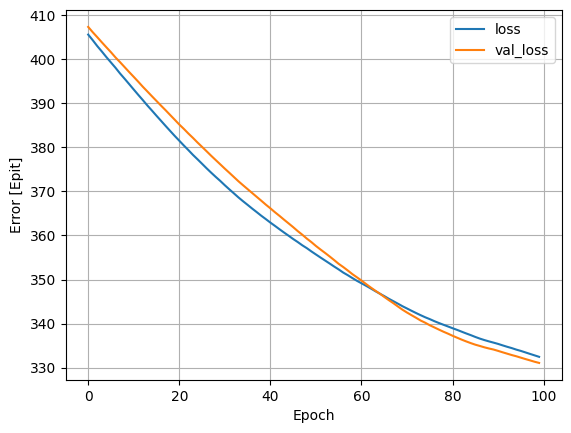

In [35]:
plot_loss(history)

We'll store the results on the test set for later:

In [36]:
test_results['Fe_model'] = Fe_model.evaluate(
    X_test['Fe'],
    y_test, verbose=0)

TypeError: 'set' object does not support item assignment

In [37]:
#Model Metrics
print("MAE for Lr Test:", mae, "MAE for Lr Train Data:", mae_t)
print("RMSE for Lr  Test:", RMSE, "RMSE for Lr  Train Data:", RMSE_t)
print("R2 for Lr  Test:", R2, "R2 for Lr  Train Data :", R2_t)
print("RMSE/MAE Ratio Test :", Ratio, "RMSE/MAE Ratio Test :", Ratio_t)

MAE for Lr Test: 307.424 MAE for Lr Train Data: 217.739
RMSE for Lr  Test: 767.215 RMSE for Lr  Train Data: 287.957
R2 for Lr  Test: -2.108 R2 for Lr  Train Data : 0.544
RMSE/MAE Ratio Test : 2.496 RMSE/MAE Ratio Test : 1.322


SInce this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [38]:
# We'll predict the Epit from Fe conc on a small set
x = tf.linspace(0.0, 250, 251)
y = Fe_model.predict(x)

2022-11-20 23:15:08.632969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [39]:
def plot_Fe(x, y):
    plt.scatter(X_train['Fe'], y_train, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Fe')
    plt.ylabel('Epit')
    plt.legend()

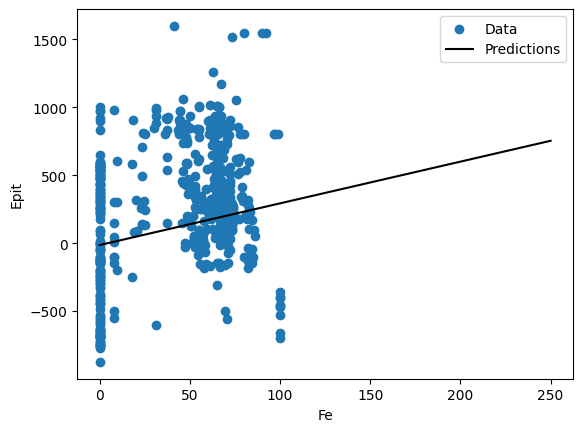

In [40]:
plot_Fe(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time we'll use the `Normalization` layer that was adapted to the whole dataset.

In [41]:
mlinear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [42]:
mlinear_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 28)               57        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 29        
                                                                 
Total params: 86
Trainable params: 29
Non-trainable params: 57
_________________________________________________________________


When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [43]:
mlinear_model.predict(X_train[:10])

2022-11-20 23:15:24.240013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.096],
       [-1.106],
       [ 1.653],
       [ 0.902],
       [-0.511],
       [ 0.749],
       [ 0.386],
       [-0.811],
       [ 2.918],
       [ 4.344]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [44]:
mlinear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(28, 1) dtype=float32, numpy=
array([[ 0.158],
       [-0.388],
       [-0.32 ],
       [ 0.111],
       [-0.442],
       [ 0.351],
       [-0.287],
       [-0.398],
       [ 0.048],
       [ 0.287],
       [-0.054],
       [ 0.295],
       [ 0.227],
       [ 0.211],
       [-0.385],
       [-0.085],
       [ 0.264],
       [ 0.347],
       [ 0.132],
       [ 0.344],
       [-0.235],
       [ 0.363],
       [-0.447],
       [ 0.314],
       [-0.202],
       [ 0.122],
       [-0.124],
       [ 0.011]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `Fe` model:

In [45]:
mlinear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mae',
    metrics='mse')

In [46]:
%%time
history = mlinear_model.fit(
    X_train, y_train, 
    epochs=100,
    # suppress logging (again: change it to 1 if you want to print more information about each epoch)
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    # Store information for TensorBoard
    callbacks=get_callbacks("linear_model"))

2022-11-20 23:15:32.359695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-20 23:15:33.274329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 12.1 s, sys: 6.28 s, total: 18.3 s
Wall time: 17.4 s


Using all the inputs achieves a much lower training and validation error than the `Fe` model: 

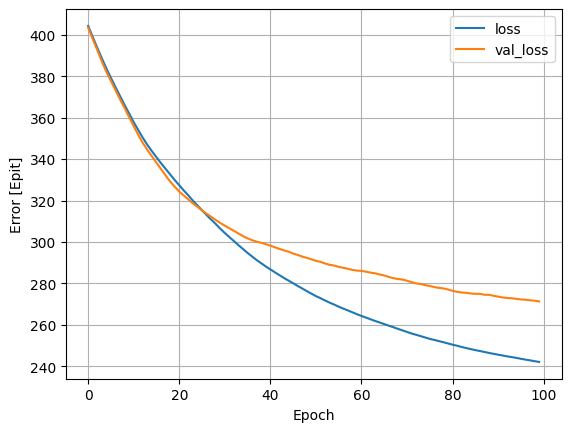

In [47]:
plot_loss(history)

We'll collect the test set result in our previously defined dictionary for later:

In [49]:
test_results['mlinear_model'] = mlinear_model.evaluate(
    X_test, y_test, verbose=0)

TypeError: 'set' object does not support item assignment

In [50]:
#Model Metrics
print("MAE for Lr Test:", mae, "MAE for Lr Train Data:", mae_t)
print("RMSE for Lr  Test:", RMSE, "RMSE for Lr  Train Data:", RMSE_t)
print("R2 for Lr  Test:", R2, "R2 for Lr  Train Data :", R2_t)
print("RMSE/MAE Ratio Test :", Ratio, "RMSE/MAE Ratio Test :", Ratio_t)

MAE for Lr Test: 307.424 MAE for Lr Train Data: 217.739
RMSE for Lr  Test: 767.215 RMSE for Lr  Train Data: 287.957
R2 for Lr  Test: -2.108 R2 for Lr  Train Data : 0.544
RMSE/MAE Ratio Test : 2.496 RMSE/MAE Ratio Test : 1.322



|MAE for Lr Test:| 413.912 |MAE for Lr Train Data: |234.51|
|-|-|-|-|
|RMSE for Lr  Test:| 1373.65 |RMSE for Lr  Train Data: |305.441|
|R2 for Lr  Test: |-8.962 |R2 for Lr  Train Data :| 0.487|
|RMSE/MAE Ratio Test :| 3.32 |RMSE/MAE Ratio Test :| 1.30|

## Performance

Now that all the models are trained let's check the test-set performance and compare how they performed:

In [51]:
pd.DataFrame(test_results, index=['Mean absolute error [Epit]', 'Root Mean squared error [Epit]', 'R2[Epit]', 'Ratio[Epit]']).T

,Mean absolute error [Epit],Root Mean squared error [Epit],R2[Epit],Ratio[Epit]
0,2.496,307.424,-2.108,767.215


These results match the validation error seen during training.

---
## TensorBoard

In machine learning, to improve something you often need to be able to measure it. TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

TensorBoard can be used directly within a notebook in Colab and Jupyter. This can be helpful for sharing results, integrating TensorBoard into existing workflows, and using TensorBoard without installing anything locally.

You can find a nice introductory notebook [here](https://www.tensorflow.org/tensorboard/get_started).

When you are running this NB in a browster and the tensorboard cannot be displayed: If you are using Safari, try to switch to Google Chrome and run it again.

### Example using TensorBoard

When training with Keras's `.fit()`, adding the `tf.keras.callbacks.TensorBoard` callback ensures that logs are created and stored. Additionally, enable histogram computation every epoch with histogram_freq=1 (this is turned off by default).

We've saved the logs in a timestamped subdirectory to allow easy selection of different training runs.

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

: 

: 

You can start TensorBoard within the notebook using magics. At the end of the command you need to specify the path where the log files are saved.

In [ ]:
%tensorboard --logdir=./my_logs

: 

: 